In [5]:
try:
    from anytree import Node
except:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "anytree"])
    print("Installed anytree")

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from anytree import Node
from random import choices
from math import log2 as log
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from sklearn import datasets

In [6]:
# Function to print a decision tree
def print_tree(node, depth):
    s = ''
    for i in range(depth):
        s += '\t'
    if node.label != 'leaf':
        print(s+ " " + str(node.edge) + " " + node.name + ' ' + node.label)
    elif node.label == 'leaf':
        print(s+ " " + str(node.edge) + " " + node.name + ' ' + node.label + " " + str(node.value))
        return
    for child in node.children:
        print_tree(child, depth+1)


# Function to create bootstrap datasets given a (dataset, ntree) pair
def get_bootstrap_datasets(ntree, dataset):
    bootstraps = []
    for tree in range(ntree):
        indices = dataset.sample(frac=1, replace=True).index
        bootstraps.append(dataset.loc[indices])
    return bootstraps


# Function to create k folds given a (datset,k) pair
# (X_train[0],X_test[0]) represents a single fold
def get_crossValidation_datasets(K, dataset):
    classes = dataset.target.unique()
    k_folds = []
    for cls in classes:
        df_cls = dataset[dataset.target == cls]
        #np.random.seed(42)
        k_folds.append(np.array_split(df_cls.reindex(np.random.permutation(df_cls.index)), K))

    X_train = []
    X_test = []
    for k in range(K):
        train = []
        test = []
        for fold in k_folds:
            b = [x for i,x in enumerate(fold) if i != k]
            c = [x for i,x in enumerate(fold) if i == k]
            train.append(pd.concat(b))
            test.append(pd.concat(c))
        X_train.append(pd.concat(train))
        X_test.append(pd.concat(test))

    return X_train, X_test


''' Performing one hot encoding'''
def one_hotencoding(dataset, col):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(dataset[[col]]).toarray())
    dataset = dataset.join(enc_df)
    for j in range(len(dataset[col].unique())):
        st = col + '_' + str(j)
        dataset.rename(columns={j: st}, inplace=True)
    del dataset[col]
    return dataset


'''
This function return a dictionary with column names as keys and their type as value
  - I set threshold = 5 to comply with votes,cancer,wine datasets in HW3. 
  - In general, we need to set after analyzing the datasets & the performance of trained models.
'''
def get_column_types(df):

    threshold = 5
    types = {}
    # for col in df.columns:
    #     if col !='Loan_Status' :
    #         df = one_hotencoding(df, col)
    #         break

    for col in df.columns:
        if df[col].nunique() < threshold:
            types[col] = ['categorical', list(df[col].unique())]
        else:
            types[col] = ['numerical']
    return types

In [7]:
# Information gain using Entropy - RELATED FUNCTIONS

'''
This function computes the Loss = negative summation of log probabilities 
  - which intuitively translates to entropy (randomness in the data)
'''
def entropy(df):
    value_count = df.target.value_counts()
    total = df.target.size
    logProb = 0
    for label in value_count.index:
        prob = value_count[label]/total
        logProb += (prob)*log(prob)
    return (-logProb)

'''
This function computes 
    - weighted average loss which translates to entropy of data (df)
    - conditioned on a decision column (col)
'''
def get_split_entropy(df,col,col_type):
    loss = 0
    if col_type == 'categorical':
        for type in set(df[col].values):
            temp = df[df[col] == type]
            loss += entropy(temp)*temp.size
    else:
        mean = df[col].mean()
        left = df[df[col] <= mean]
        loss += entropy(left) * left.size
        right = df[df[col] > mean]
        loss += entropy(right) * right.size
    return loss/df.size

'''
This function computes the information gain (IG) given a list of attributes (attrs)
    - returns the attribute with highest information gain
'''
def choose_attr(df, attrs, types):
    I = entropy(df)
    gain_dict = []
    for col in attrs:
        i = get_split_entropy(df,col,types[col][0])
        information_gain = I-i
        gain_dict.append([col,information_gain])
    gain_df = pd.DataFrame(gain_dict).set_index(0)
    idx = gain_df[1].idxmax()
    value = gain_df.loc[idx][1]
    return idx, value

In [8]:
# Information gain using GINI - RELATED FUNCTIONS

'''
This function computes the gini coefficient of a dataset = (1-summation(square of probabilities)) 
  - which intuitively translates to randomness/unevenness in the data 
  (its behavior is similar to entropy (-summation(logProb)) in the extreme ends)
'''
def gini_coefficient(df):
    value_count = df.target.value_counts()
    total = df.target.size
    square_prob = 0
    for label in value_count.index:
        prob = value_count[label]/total
        square_prob += (prob)*(prob)
    return (1-square_prob)

'''
This function computes 
    - weighted gini coefficient of a dataset (df)
    - conditioned on a decision column (col)
'''
def get_split_gini(df,col,col_type):
    gini = 0
    if col_type == 'categorical':
        for type in set(df[col].values):
            temp = df[df[col]==type]
            gini += gini_coefficient(temp) * temp.size
    else:
        mean = df[col].mean()
        left = df[df[col] <= mean]
        gini += gini_coefficient(left) * left.size
        right = df[df[col] > mean]
        gini += gini_coefficient(right) * right.size
    return gini/df.size

'''
This function computes the gini criterian, given a list of attributes (attrs)
    - returns the attribute with lowest gini criterian, which means the highest homogeneity
'''
def choose_attr_gini(df, attrs, types):
    gini = 10
    attribute = 'none'
    for col in attrs:
        gini_temp = get_split_gini(df,col,types[col])
        if gini_temp <= gini:
            gini = gini_temp
            attribute = col
    return attribute, gini

In [9]:
'''
  This function builds the decision tree and returns the root node
      - df : training data (in pandas dataframe)
      - L : Set of all attributes/feayures (pandas columns)
      - l : random sqrt(len(L)) attributes chosen from L without replacement
      - types : column types (dictionary)
      - criteria : "entropy", "gini" (string)
'''
def decision_tree(df, L, types, criteria, minimal_gain=0.01):
    N = Node('node', label = 'node', value = -100, edge = 'none', mean = -100)
    if df.target.nunique() == 1:
        N.label = 'leaf'
        N.value = df.target.iloc[0]
        return N

    l = list(np.random.choice(L, round(np.sqrt(len(L))), replace=False))
    if (criteria == 'entropy'):
        A, gain = choose_attr(df, l, types)
        if (gain < minimal_gain):
            N.label = 'leaf'
            N.value = df.target.value_counts().idxmax()
            return N
    else:
        A, gini = choose_attr_gini(df, l, types)
        if gini >= 1-(1/df.target.nunique()):
            N.label = 'leaf'
            N.value = df.target.value_counts().idxmax()
            return N

    N.name = A
    if types[A][0] == 'categorical':
        V = types[A][1]
        for v in V:
            df_v = df[df[A] == v]
            if df_v.target.empty:
                N.label = 'leaf'
                N.value = df.target.value_counts().idxmax()
                return N
            T_v = decision_tree(df_v, L, types, criteria, minimal_gain)
            T_v.parent = N
            T_v.edge = v
    else:
        v = df[A].mean()
        df_v_left  = df[df[A] <= v]
        df_v_right = df[df[A] > v]
        
        if df_v_right.target.empty or df_v_left.target.empty:
            N.label = 'leaf'
            N.value = df.target.value_counts().idxmax()
            return N
        else:
            T_v = decision_tree(df_v_left, L, types, criteria, minimal_gain)
            T_v.parent = N
            T_v.edge = 'less'
            T_v.mean = v

            T_v = decision_tree(df_v_right, L, types, criteria, minimal_gain)
            T_v.parent = N
            T_v.edge = 'more'
            T_v.mean = v
    return N

In [10]:
'''Function that classifies, given a X_test instance'''
def traverse(dt, X_test):
    if dt.label == 'leaf':
        return dt.value
    A = dt.name
    v = X_test[A]
    for child in dt.children:
        if (child.edge == 'less' and v <= child.mean) or (child.edge == 'more' and v > child.mean) or (child.edge == v):
            return traverse(child, X_test)

In [11]:
def print_graphs(ntree, values, criteria):
    y_axis = ['Accuracy', 'Precision', 'Recall', 'F1']
    for i in range(4):
        plt.plot(ntree, [value[i] for value in values], '-bo')
        plt.xlabel("ntree")
        plt.ylabel(y_axis[i])
        plt.title(criteria)
        plt.show()

In [12]:
def train(ntree, K, X, criteria, minimum_gain=0.05):
    L = list(X.columns)
    L.remove('target')
    types = get_column_types(X)
    #print(types)
    accuracy = precision = recall = f1 = 0
    X_train, X_test = get_crossValidation_datasets(K, dataset=X)
    for k in range(K):
        a = r = p = f = 0
        trees = []
        train = X_train[k]
        x = X_test[k]
        
        bootstraps = get_bootstrap_datasets(ntree, train)
        for idx in range(ntree):
            dt = decision_tree(bootstraps[idx], L, types, criteria, minimum_gain)
            trees.append(dt)
        
        for idx in range(ntree):
            x['predicted_'+str(idx)] = x.apply(lambda row : traverse(trees[idx], row), axis = 1)
        x['majority'] = x[list(set(x.columns)-set(train.columns))].mode(axis=1)[0]
        
        total = len(x)
        n = x.target.nunique()
        for c in x.target.unique():
            tp = len(x[(x.target == x.majority) & (x.target == c)])
            tn = len(x[(x.target != c) & (x.majority != c)])
            fn = len(x[(x.target == c) & (x.majority != x.target)])
            fp = len(x[(x.majority == c) & (x.majority != x.target)])
            a += (tp+tn)/total
            try:
                r += tp/(tp+fn)
            except:
                pass
            try:
                p += tp/(tp+fp)
            except:
                pass
            try:
                f += (2*tp)/(2*tp+fn+fp)
            except:
                pass
        accuracy += a/n
        precision += p/n
        recall += r/n
        f1 += f/n
        
        del bootstraps
        del trees
        gc.collect()
    
    return [accuracy/K, precision/K, recall/K, f1/K]

In [14]:
df = pd.read_csv('./data/loan.csv')
df.rename(columns={"Loan_Status": "target"}, inplace = True)
del df["Loan_ID"]

for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes

ntree = [1,5,10,20,30,40,50]
values = []
for n in ntree:
    a, p, r, f1 = train(n, 10, df, 'gini')
    print("ntree = ", n)
    print("Acc.  = ", a, " Prec. = ", p, " Recall = ", r, " F1 = ", f1)
    values.append([a,p,r,f1])

ntree =  1
Acc.  =  0.7125877478651035  Prec. =  0.6710034249004837  Recall =  0.6341010949834479  F1 =  0.637314900964873
ntree =  5
Acc.  =  0.7499511506730352  Prec. =  0.7109966280709313  Recall =  0.6596625923096512  F1 =  0.6678824896363832


KeyboardInterrupt: 

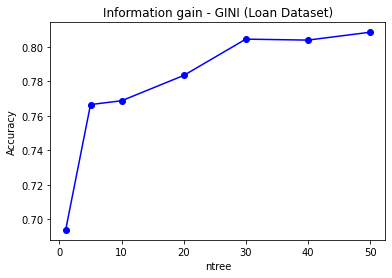

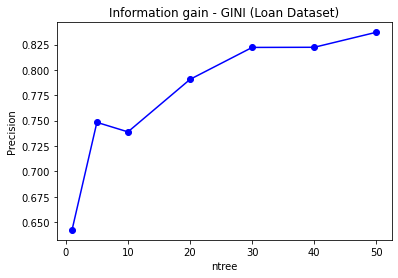

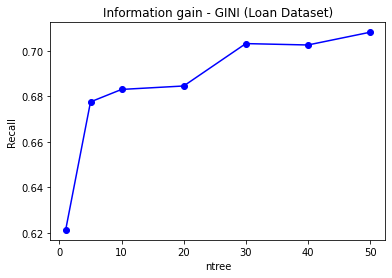

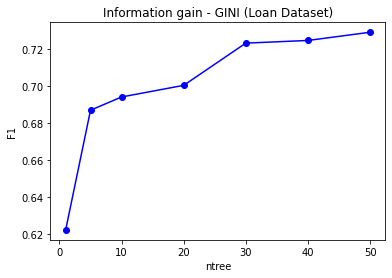

In [ ]:
print_graphs(ntree, values, "Information gain - GINI (Loan Dataset)")

In [ ]:
df = pd.read_csv('./data/parkinsons.csv')
df.rename(columns={"Diagnosis": "target"}, inplace = True)
ntree = [1,5,10,20,30,40,50]
values = []
for n in ntree:
    a, p, r, f1 = train(n, 10, df, 'gini')
    print("ntree = ", n)
    print("Acc.  = ", a, " Prec. = ", p, " Recall = ", r, " F1 = ", f1)
    values.append([a,p,r,f1])

ntree =  1
Acc.  =  0.8114035087719298  Prec. =  0.7556705182072829  Recall =  0.7638095238095239  F1 =  0.7495405682666527
ntree =  5
Acc.  =  0.8561695906432749  Prec. =  0.8067261904761907  Recall =  0.7917857142857144  F1 =  0.7908575478820195
ntree =  10
Acc.  =  0.9328070175438598  Prec. =  0.9113988095238096  Recall =  0.9067857142857141  F1 =  0.9065009315037124
ntree =  20
Acc.  =  0.907514619883041  Prec. =  0.8815705128205129  Recall =  0.8898809523809523  F1 =  0.8735874076280081
ntree =  30
Acc.  =  0.9130701754385966  Prec. =  0.9025997899159665  Recall =  0.8647619047619048  F1 =  0.8780076036465081
ntree =  40
Acc.  =  0.9016959064327486  Prec. =  0.8984628851540617  Recall =  0.8353571428571428  F1 =  0.8515137480397492
ntree =  50
Acc.  =  0.917543859649123  Prec. =  0.9088095238095238  Recall =  0.8789285714285715  F1 =  0.8846405417595629


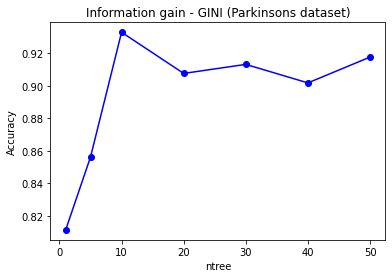

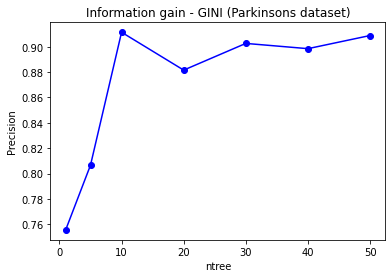

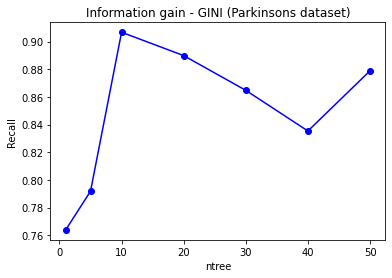

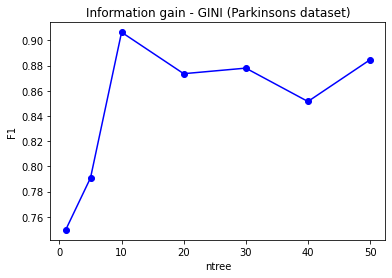

In [ ]:
print_graphs(ntree, values, "Information gain - GINI (Parkinsons dataset)")

In [ ]:
df = pd.read_csv('./data/titanic.csv')
df.rename(columns={"Survived": "target"}, inplace = True)
del df["Name"]
#print(df)
for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes
ntree = [1,5,10,20,30,40,50]
values = []
for n in ntree:
    a, p, r, f1 = train(n, 10, df, 'gini')
    print("ntree = ", n)
    print("Acc.  = ", a, " Prec. = ", p, " Recall = ", r, " F1 = ", f1)
    values.append([a,p,r,f1])

ntree =  1
Acc.  =  0.7711584950629895  Prec. =  0.7669386824550802  Recall =  0.7481577681577681  F1 =  0.7504591246825052
ntree =  5
Acc.  =  0.8014345704233344  Prec. =  0.8049014776541588  Recall =  0.7723267690914749  F1 =  0.7802319422188642
ntree =  10
Acc.  =  0.8049951764839406  Prec. =  0.8062446261805756  Recall =  0.7764629488158901  F1 =  0.7852022233101122
ntree =  20
Acc.  =  0.816308024060833  Prec. =  0.8167929591153194  Recall =  0.7929288685171038  F1 =  0.7998611504316989
ntree =  30
Acc.  =  0.811838327091136  Prec. =  0.8095381928650476  Recall =  0.7880351130351131  F1 =  0.7947735268133662
ntree =  40
Acc.  =  0.8218258426966292  Prec. =  0.8211726535812816  Recall =  0.7986882833941658  F1 =  0.8049884958781091
ntree =  50
Acc.  =  0.8127604698672114  Prec. =  0.8088091172386477  Recall =  0.7913398692810458  F1 =  0.7963733767422277


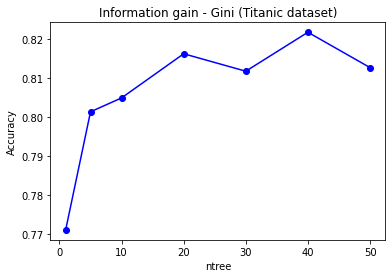

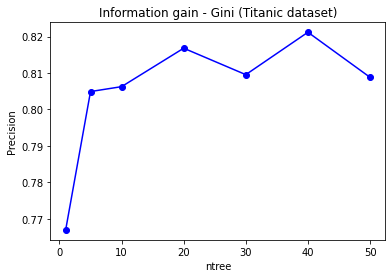

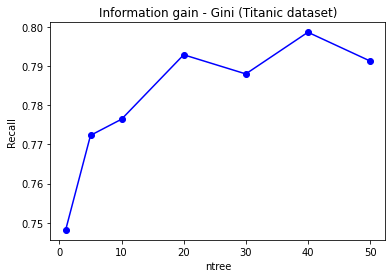

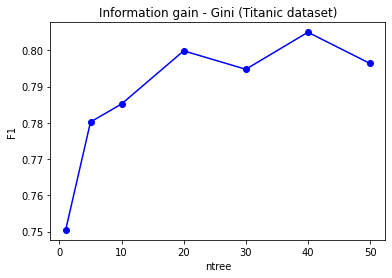

In [ ]:
print_graphs(ntree, values, "Information gain - Gini (Titanic dataset)")

In [ ]:
digits = datasets.load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
labels = digits.target

data_df = pd.DataFrame(data, columns = digits.feature_names)
labels_df = pd.DataFrame(labels, columns = ['target'])

dataset = pd.concat([data_df, labels_df], axis = 1)
dataset[digits.feature_names] = (dataset[digits.feature_names] - dataset[digits.feature_names].min())/(dataset[digits.feature_names].max() - dataset[digits.feature_names].min())
dataset.fillna(0, inplace=True)


#dataset.rename(columns={"Class": "target"}, inplace = True)
ntree = [1,5,10,20,30,40,50]
values = []
for n in ntree:
    a, p, r, f1 = train(n, 10, dataset, 'entropy')
    print("ntree = ", n)
    print("Acc.  = ", a, " Prec. = ", p, " Recall = ", r, " F1 = ", f1)
    values.append([a,p,r,f1])

ntree =  1
Acc.  =  0.9499310018950066  Prec. =  0.7594249601989371  Recall =  0.7489508083935329  F1 =  0.747561618313647
ntree =  5
Acc.  =  0.9809577551117143  Prec. =  0.9101441235810599  Recall =  0.9043567251461988  F1 =  0.9034324305471099
ntree =  10
Acc.  =  0.9901928232916399  Prec. =  0.9535659681735533  Recall =  0.9508771929824562  F1 =  0.9506110199475201
ntree =  20
Acc.  =  0.9939931797180692  Prec. =  0.9711173030615754  Recall =  0.9699036807705539  F1 =  0.9698419643512523
ntree =  30
Acc.  =  0.9943160460931798  Prec. =  0.973223404991981  Recall =  0.9714207086343312  F1 =  0.9713559699649907
ntree =  40
Acc.  =  0.995664004834081  Prec. =  0.9793030615755074  Recall =  0.9783195734434124  F1 =  0.978413908918553
ntree =  50
Acc.  =  0.9952242250731851  Prec. =  0.9773235294117647  Recall =  0.9760904712762299  F1 =  0.9761126591219471


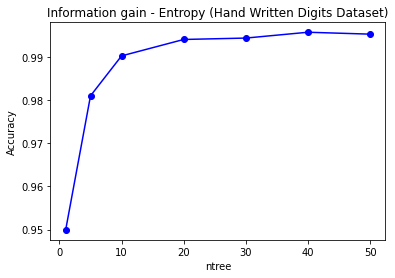

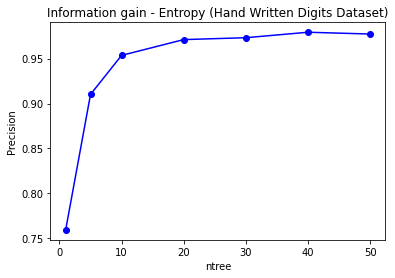

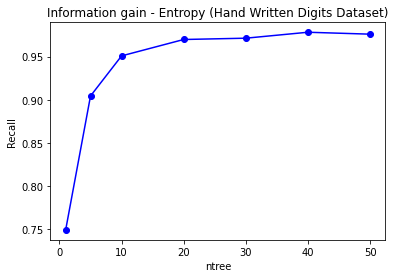

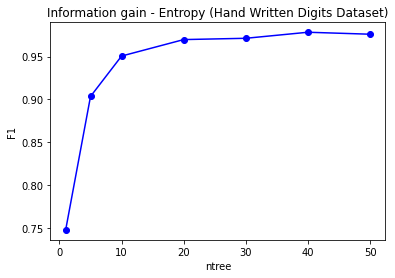

In [ ]:
print_graphs(ntree, values, "Information gain - Entropy (Hand Written Digits Dataset)")

In [19]:
df = pd.read_csv('./data/Telecust1.csv')
df.rename(columns={"custcat": "target"}, inplace = True)
ntree = [1,5,10,20,30,40,50]
values = []
for n in ntree:
    a, p, r, f1 = train(n, 10, df, 'gini')
    print("ntree = ", n)
    print("Acc.  = ", a, " Prec. = ", p, " Recall = ", r, " F1 = ", f1)
    values.append([a,p,r,f1])

ntree =  1
Acc.  =  0.6626006838378916  Prec. =  0.3191006170712799  Recall =  0.3199547627396203  F1 =  0.31686662959471207
ntree =  5
Acc.  =  0.6588995003942171  Prec. =  0.31831491809799467  Recall =  0.3149216636894673  F1 =  0.3107715984007723
ntree =  10
Acc.  =  0.6714366904877763  Prec. =  0.3464371435517842  Recall =  0.33763728826978456  F1 =  0.3354899633002012
ntree =  20
Acc.  =  0.6665119573181809  Prec. =  0.3306780011467502  Recall =  0.3288649298394425  F1 =  0.325604541281849
ntree =  30
Acc.  =  0.6703208015879619  Prec. =  0.3351674517173011  Recall =  0.3336297635398085  F1 =  0.33094552447162695
ntree =  40
Acc.  =  0.676519929904155  Prec. =  0.34273031850559854  Recall =  0.34607810268885986  F1 =  0.3409192495754236
ntree =  50
Acc.  =  0.6765029804300958  Prec. =  0.35039134361685403  Recall =  0.3447411679608081  F1 =  0.34201353316590916


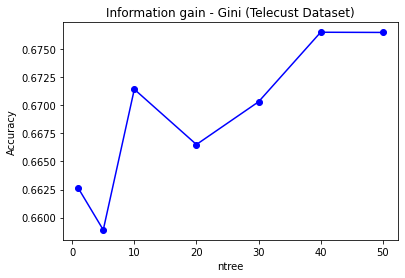

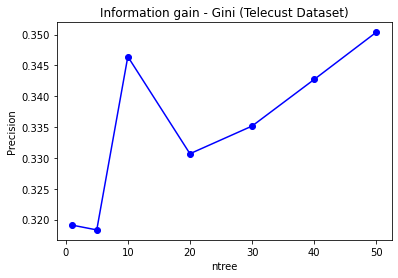

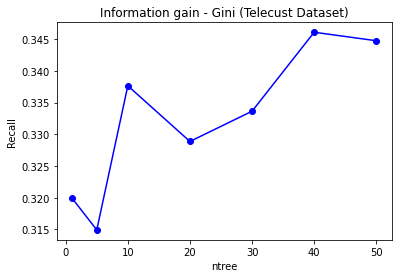

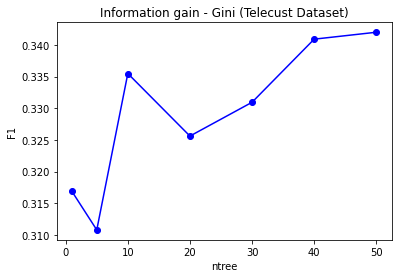

In [20]:
print_graphs(ntree, values, "Information gain - Gini (Telecust Dataset)")